In [1]:
# install requirements
#!pip install numpy pandas scikit-learn matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath('../src'))

# Make an experimental design table
Here the settings for the experiments can be modified in the dictionary called run_settings. Refer to the paper for more details on of each of the parameters.

In [3]:
run_settings = {# level of entropy: min, medium and/or max
                "process_entropy":["min_entropy"], #"min_entropy","med_entropy","max_entropy"
                
                # number of traces/cases in the event-log
                "number_of_traces":[500],

                # number of activity types
                "statespace_size":[5], 

                # first or higher-order markov chain to represent the transitions
                "process_type":["memoryless"], 
                
                # order of HOMC - only specify this when using process with memory
                "process_memory":[1],
                
                # number of transitions - only used for medium entropy (should be higher than 2 and < statespace size)
                "med_ent_n_transitions":[2],
                                
                # lambda parameter of inter-arrival times
                "inter_arrival_time":[1],
                
                # lambda parameter of process noise
                "process_stability_scale":[0.5],
                
                # probability of agent being available
                "resource_availability_p":[0.25, 0.99],

                # number of agents in the process
                "resource_availability_n":[3],

                # waiting time in full days, when no agent is available
                "resource_availability_m":[0.041],
                
                # variation between activity durations
                "activity_duration_lambda_range":[1],
                
                # business hours definition: when can cases be processed?
                "Deterministic_offset_W":["weekdays"],

                # time-unit for a full week: days = 7, hrs = 24*7, etc.
                "Deterministic_offset_u":[7],
                
                # offset for the timestamps used (years after 1970)
                "datetime_offset":[54],
                
                # number of repetitions of the experiments: duplicates the experiment table (2 times here)
                "num_replications":list(range(0, 100))
               }


# import the make_design_table function to generate a full factorial experimental design table
from SynBPS.design.DoE import make_design_table
df = make_design_table(run_settings)

# give each run its own seed value such that results are different across runs
df["seed_value"] = range(0,len(df))

# store the design table
df.to_csv("data/design_table.csv", index=False)

# inspect the resulting design table
df

,process_entropy,number_of_traces,statespace_size,process_type,process_memory,med_ent_n_transitions,inter_arrival_time,process_stability_scale,resource_availability_p,resource_availability_n,resource_availability_m,activity_duration_lambda_range,Deterministic_offset_W,Deterministic_offset_u,datetime_offset,num_replications,RUN,Done,Failure,seed_value
0,min_entropy,500,5,memoryless,1,2,1,0.5,0.25,3,0.041,1,weekdays,7,54,0,1,0,0,0
1,min_entropy,500,5,memoryless,1,2,1,0.5,0.25,3,0.041,1,weekdays,7,54,1,2,0,0,1
2,min_entropy,500,5,memoryless,1,2,1,0.5,0.25,3,0.041,1,weekdays,7,54,2,3,0,0,2
3,min_entropy,500,5,memoryless,1,2,1,0.5,0.25,3,0.041,1,weekdays,7,54,3,4,0,0,3
4,min_entropy,500,5,memoryless,1,2,1,0.5,0.25,3,0.041,1,weekdays,7,54,4,5,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,min_entropy,500,5,memoryless,1,2,1,0.5,0.99,3,0.041,1,weekdays,7,54,95,196,0,0,195
196,min_entropy,500,5,memoryless,1,2,1,0.5,0.99,3,0.041,1,weekdays,7,54,96,197,0,0,196
197,min_entropy,500,5,memoryless,1,2,1,0.5,0.99,3,0.041,1,weekdays,7,54,97,198,0,0,197
198,min_entropy,500,5,memoryless,1,2,1,0.5,0.99,3,0.041,1,weekdays,7,54,98,199,0,0,198


# Specify dataprep_function()
If desired, the datapreparation can be specified in a function as below. The output of the process should be a dictionary containing the train and test sets

In [4]:
def dataprep_function(log):
    """
    Function used to prepare the data from event-log to prefix or other.

    Parameters
    -------
    log : a dataframe event-log generated by simulate_eventlog module
    
    Returns
    -------
    input_data : a dictionary of elements
                        x_train: the inputs of the train set
                        x_test: the inputs of the test set
                        y_train: the target of the train set 
                        y_test: the target of the test set 
                        inference_test: the test partition of raw event-log with target values "y"
    """
    
    # High-level helper for prefix-log format: useful for autoregressive models

    #from SynBPS.dataprep.prepare import prefix_data
    #input_data = prefix_data(log, verbose=False)

    """
    # here you can also specify your own custom dataprep pipeline as seen below
    """
    from sklearn.model_selection import train_test_split

    ## step 1: drop everything except the first event for this example 
    log = log.groupby('caseid').first().reset_index()

    ## step 2: assign a target variable
    y = log["u_t"] # the total duration of the event incl. delays

    ## step 3: subset the features needed
    X = log[["activity","activity_no","z_t", "q_t",	"h_t","b_t","s_t"]] # here we know everything else than the activity duration

    ## step 4: make dummies / oh encode
    X = pd.get_dummies(X, columns=['activity'], prefix='activity')
 
    ## step 5: Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    # this element can be used for detailed error-analysis
    inference_test = x_test
    inference_test["y"] = y_test

    # step 6: store to dictionary
    input_data = {"x_train":x_train,
                  "x_test":x_test,
                  "y_train":y_train,
                  "y_test":y_test,
                  "Inference_test":inference_test}

    return input_data

# Specify training_function() and eval_function()
Before running the experiments, you need to define model training and evaluation functions.

In this example we train a first state model, which is a model using only the first observed event (state) to predict to total cycle-time. The default data preparation will result in a prefix-log, which can be used to predict remaining cycle-time from every observed event in the trace.

Input for the **training_function** is a dictionary named **input_data**, which contain the following:
- x_train
- x_test
- y_train
- y_test

Output is an **inference table** containing predictions and actual target values for the test data. This table is used for analysis of the results. The **eval_function** also uses this table to calculate aggregated metrics.

In [5]:
def training_function(input_data):    
    """
    Example model: Lasso regression
    Here we fit a regressor to the target variable on the train set and predict on the test set
    """

    #retrieve model class from sklearn
    from sklearn import linear_model

    #get prod class from numpy for flattening the inputs
    from numpy import prod

    # Lasso model
    reg = linear_model.Lasso(alpha=0.1)
    
    # OLS
    #reg = linear_model.LinearRegression()

    #train the regression model
    reg.fit(input_data["x_train"], input_data["y_train"])

    #predict on the test data
    y_pred = reg.predict(input_data["x_test"].drop("y",axis=1))

    #get the inference table (used for analysis of the final results)
    inference = input_data["Inference_test"]
    
    #add predictions to the inference table
    inference["y_pred"] = y_pred
    return inference

def eval_function(inference):
    """
    Example evaluation: Aggregated scores
    The inference table also enable the ability to make trace or prefix-level evaluations using its id variables
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

    y = inference["y"]
    y_pred = inference["y_pred"]

    MSE = mean_squared_error(y, y_pred)
    MAE = mean_absolute_error(y, y_pred)
    R2 = r2_score(y, y_pred)
    EVAR = explained_variance_score(y, y_pred)

    # the resulting metrics should be stored in a dictionary and be scalars only
    # adding prefixes to column name (key) is suggested when logging many metrics
    metrics = {"TEST_MSE":MSE,
              "TEST_MAE":MAE,
              "TEST_R2":R2,
              "TEST_EVAR":EVAR}
    #print(metrics)
    return metrics

# Perform the experiments
Now we perform the experiments using the defined training and evaluation functions. 
Here we can for instance choose whether to store all the generated eventlogs - if set to False, we will only get the aggregated results.

In [6]:
from SynBPS.simulation.simulation_pipeline import run_experiments

# function to run a set of experiments
results = run_experiments(dataprep_function,
                          training_function, 
                          eval_function, 
                          store_eventlogs=False,
                          output_dir="data/",
                          out_file="results.csv", 
                          design_table="design_table.csv")

100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


In [7]:
# if we have stored the eventlogs, we can have a look at them individually like this
log = pd.read_csv("data/run_0_eventlog.csv")
log.head()

,caseid,activity,activity_no,y_acc_sum,z_t,n_t,q_t,h_t,b_t,s_t,v_t,u_t,starttime,endtime,arrival_datetime,start_datetime,end_datetime,start_day,start_hour
0,0,f,1,0.906996,0.795875,0.795875,0.836875,0.041,0,0.0,0.865996,0.906996,0.836875,1.702870,2024-01-02 13:06:03,2024-01-02 14:05:05,2024-01-03 10:52:07,Tuesday,14
1,0,d,2,1.056089,0.795875,1.702870,1.743870,0.041,0,0.0,0.108093,0.149093,1.743870,1.851964,2024-01-02 13:06:03,2024-01-03 11:51:10,2024-01-03 14:26:49,Wednesday,11
2,0,b,3,1.904029,0.795875,1.851964,1.892964,0.041,0,0.0,0.806940,0.847940,1.892964,2.699903,2024-01-02 13:06:03,2024-01-03 15:25:52,2024-01-04 10:47:51,Wednesday,15
3,0,c,4,3.050532,0.795875,2.699903,2.740903,0.041,0,0.0,1.105504,1.146504,2.740903,3.846407,2024-01-02 13:06:03,2024-01-04 11:46:54,2024-01-05 14:18:49,Thursday,11
4,0,e,5,3.411754,0.795875,3.846407,3.928407,0.082,0,0.0,0.279222,0.361222,3.928407,4.207629,2024-01-02 13:06:03,2024-01-05 16:16:54,2024-01-05 22:58:59,Friday,16


# Analysis
Firstly we load the results table which is the design table with aggregated metrics based on the individual runs.

In [8]:
import pandas as pd
df = pd.read_csv("data/results.csv")
df

,process_entropy,number_of_traces,statespace_size,process_type,process_memory,med_ent_n_transitions,inter_arrival_time,process_stability_scale,resource_availability_p,resource_availability_n,...,stdev_eventduration,min_eventduration,max_eventduration,avg_r_waitingtimes,avg_s_waitingtimes,RESULT_num_events,TEST_MSE,TEST_MAE,TEST_R2,TEST_EVAR
0,min_entropy,500,5,memoryless,1,2,1,0.5,0.25,3,...,0.267006,0.099357,2.045046,0.071209,0.496283,2500,0.101113,0.257835,0.817721,0.820671
1,min_entropy,500,5,memoryless,1,2,1,0.5,0.25,3,...,0.272317,0.073929,1.703259,0.068618,0.494843,2500,0.502999,0.533310,0.500478,0.515448
2,min_entropy,500,5,memoryless,1,2,1,0.5,0.25,3,...,0.291713,0.122870,1.897396,0.070979,0.484673,2500,0.801098,0.655856,0.398430,0.399006
3,min_entropy,500,5,memoryless,1,2,1,0.5,0.25,3,...,0.348365,0.058372,2.359608,0.070208,0.503125,2500,0.145299,0.287163,0.856844,0.858663
4,min_entropy,500,5,memoryless,1,2,1,0.5,0.25,3,...,0.188449,0.047022,1.214788,0.072800,0.504478,2500,0.079378,0.226004,0.890592,0.890924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,min_entropy,500,5,memoryless,1,2,1,0.5,0.99,3,...,0.196866,0.041278,1.060917,0.041000,0.484564,2500,0.969558,0.776366,0.416390,0.416391
196,min_entropy,500,5,memoryless,1,2,1,0.5,0.99,3,...,0.242249,0.088995,1.367446,0.041000,0.488604,2500,0.061556,0.193108,0.903345,0.903661
197,min_entropy,500,5,memoryless,1,2,1,0.5,0.99,3,...,0.258525,0.033780,2.130173,0.041000,0.509187,2500,0.047749,0.178815,0.927610,0.928827
198,min_entropy,500,5,memoryless,1,2,1,0.5,0.99,3,...,0.288929,0.066636,1.957749,0.041000,0.509113,2500,0.419892,0.516465,0.621196,0.621365


In [9]:
# Display all the columns available for aggregated analysis
df.columns

Index(['process_entropy', 'number_of_traces', 'statespace_size',
       'process_type', 'process_memory', 'med_ent_n_transitions',
       'inter_arrival_time', 'process_stability_scale',
       'resource_availability_p', 'resource_availability_n',
       'resource_availability_m', 'activity_duration_lambda_range',
       'Deterministic_offset_W', 'Deterministic_offset_u', 'datetime_offset',
       'num_replications', 'RUN', 'Done', 'Failure', 'seed_value', 'idx',
       'simuation_time_sec', 'num_traces', 'num_events', 'num_variants',
       'avg_tracelen', 'min_tracelen', 'max_tracelen', 'avg_traceduration',
       'stdev_traceduration', 'min_traceduration', 'max_traceduration',
       'avg_eventduration', 'stdev_eventduration', 'min_eventduration',
       'max_eventduration', 'avg_r_waitingtimes', 'avg_s_waitingtimes',
       'RESULT_num_events', 'TEST_MSE', 'TEST_MAE', 'TEST_R2', 'TEST_EVAR'],
      dtype='object')

## Compare the average total trace durations vs. Resource availability
Resource availability 'p' is the probability of getting an idle agent

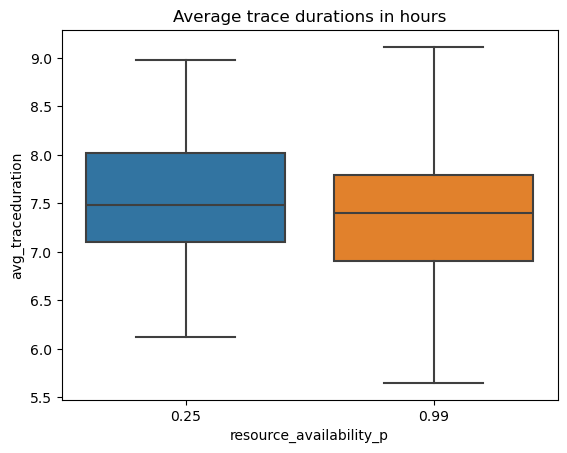

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create boxplot
sns.boxplot(data=df, x='resource_availability_p', y='avg_traceduration')

# Set title and y-axis range
plt.title('Average trace durations in hours')
#plt.ylim(0, 1)

plt.show()


## Compare the average time waiting for a resource in the two scenarios
The waiting time when no agent is available (isolated)

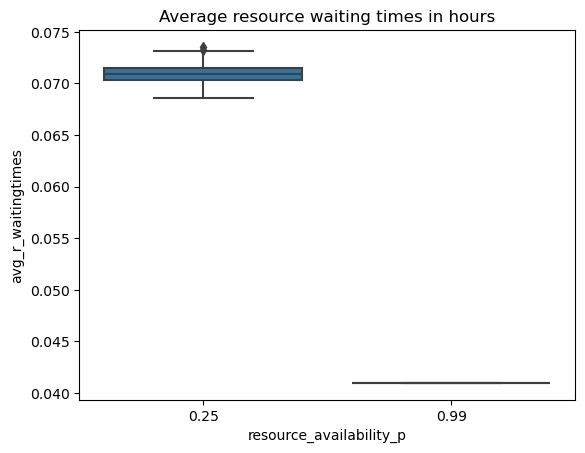

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create boxplot
sns.boxplot(data=df, x='resource_availability_p', y='avg_r_waitingtimes')

# Set title and y-axis range
plt.title('Average resource waiting times in hours')
#plt.ylim(0, 1)

plt.show()


## The delays due to an unstable process
Noise added to the duration of the activities

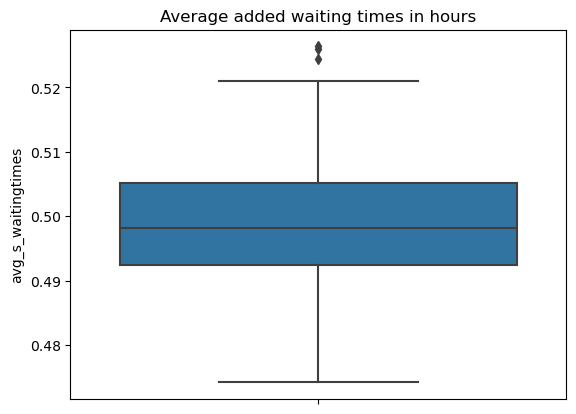

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create boxplot
sns.boxplot(data=df, y='avg_s_waitingtimes')

# Set title and y-axis range
plt.title('Average added waiting times in hours')
#plt.ylim(0, 1)

plt.show()


## Compare model performance
The difference in model performance (R2)

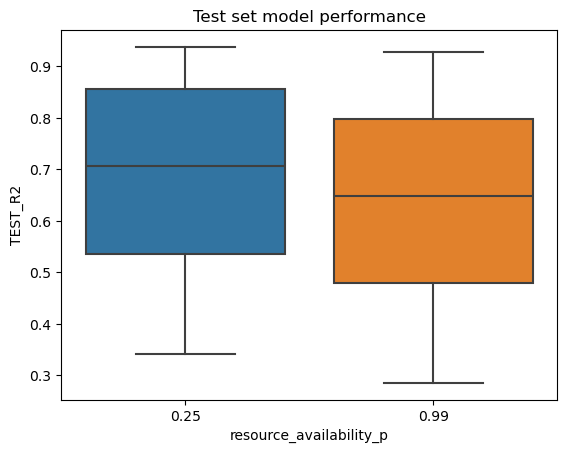

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create boxplot
sns.boxplot(data=df, x='resource_availability_p', y='TEST_R2')

# Set title and y-axis range
plt.title('Test set model performance')
#plt.ylim(0, 1)

plt.show()
